In [1]:
try:
    import qiskit
    import qiskit_aer
except ImportError:
    !pip install qiskit qiskit-aer --quiet --break-system-packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import (
    SparsePauliOp,
    Statevector,
    concurrence
)
from qiskit_aer import AerSimulator
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.visualization import plot_histogram


/home/atharva/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
# XY Hamiltonian construction

def build_xy_hamiltonian(g: float = 1.0) -> SparsePauliOp:
    """
    Build the XY Hamiltonian: H = g(XX + YY)
    """
    return SparsePauliOp.from_list([
        ("XX", g),
        ("YY", g),
    ])


def print_hamiltonian_info(g: float = 1.0):
    H = build_xy_hamiltonian(g)
    H_matrix = H.to_matrix()

    print("Hamiltonian matrix:\n", H_matrix)
    print("Hermitian?", np.allclose(H_matrix, H_matrix.conj().T))

    evals = np.linalg.eigvals(H_matrix)
    print("Eigenvalues:", evals)

    print("\nEvolution time for iSWAP: t = π/(2g) =", np.pi/(2*g))


In [4]:
print_hamiltonian_info()

Hamiltonian matrix:
 [[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 2.+0.j 0.+0.j]
 [0.+0.j 2.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
Hermitian? True
Eigenvalues: [ 2.+0.j -2.+0.j  0.+0.j  0.+0.j]

Evolution time for iSWAP: t = π/(2g) = 1.5707963267948966


In [5]:
# Time evolution + measurement

def build_iswap_xy_circuit(g: float = 1.0, t: float = None):
    if t is None:
        t = np.pi / (2 * g)

    H = build_xy_hamiltonian(g)
    evo_gate = PauliEvolutionGate(H, time=t)

    qc = QuantumCircuit(2, 2)

    qc.x(1)   # prepare |01> (q0=0, q1=1)

    qc.append(evo_gate, [0, 1])
    qc.measure([0,1], [0,1])

    return qc


def simulate_measurement(g: float = 1.0, t: float = None, shots: int = 4096):
    if t is None:
        t = np.pi/(2*g)

    qc = build_iswap_xy_circuit(g, t)

    qc = qc.decompose(reps=10)

    backend = AerSimulator()
    tqc = transpile(qc, backend)
    result = backend.run(tqc, shots=shots).result()
    counts_raw = result.get_counts()

    # Convert Qiskit order (c1c0) → physics (q0q1)

    counts_physics = {k[::-1]: v for k, v in counts_raw.items()}

    print("Raw Qiskit counts:", counts_raw)
    print("Physics-order counts (|q0 q1>):", counts_physics)

    plot_histogram(counts_physics)
    plt.show()

    return qc, counts_physics


In [6]:
qc, counts = simulate_measurement()
print(qc.draw())

Raw Qiskit counts: {'10': 4096}
Physics-order counts (|q0 q1>): {'01': 4096}
global phase: π
     ┌────────────┐                                    ┌────────────┐»
q_0: ┤ U(π/2,0,π) ├────────────────■────────────────■──┤ U(π/2,0,π) ├»
     └┬──────────┬┘┌────────────┐┌─┴─┐┌──────────┐┌─┴─┐├────────────┤»
q_1: ─┤ U(π,0,π) ├─┤ U(π/2,0,π) ├┤ X ├┤ U(0,0,π) ├┤ X ├┤ U(π/2,0,π) ├»
      └──────────┘ └────────────┘└───┘└──────────┘└───┘└────────────┘»
c: 2/════════════════════════════════════════════════════════════════»
                                                                     »
«     ┌────────────┐┌────────────┐┌────────────┐                      »
«q_0: ┤ U(0,0,π/2) ├┤ U(π/2,0,π) ├┤ U(0,0,π/2) ├──■────────────────■──»
«     ├────────────┤├────────────┤├────────────┤┌─┴─┐┌──────────┐┌─┴─┐»
«q_1: ┤ U(0,0,π/2) ├┤ U(π/2,0,π) ├┤ U(0,0,π/2) ├┤ X ├┤ U(0,0,π) ├┤ X ├»
«     └────────────┘└────────────┘└────────────┘└───┘└──────────┘└───┘»
«c: 2/════════════════════════════════════════════

In [7]:
# Concurrence dynamics

def evolve_state_xy(g: float, t: float):
    H = build_xy_hamiltonian(g)
    evo_gate = PauliEvolutionGate(H, time=t)

    qc = QuantumCircuit(2)
    qc.x(1)            # |01> initial state
    qc.append(evo_gate, [0, 1])

    qc = qc.decompose(reps=10)

    return Statevector.from_instruction(qc)


def concurrence_vs_time(g: float = 1.0, steps: int = 200):
    times = np.linspace(0, np.pi/2, steps)
    Cvals = []

    for t in times:
        psi = evolve_state_xy(g, t)
        Cvals.append(concurrence(psi))

    return times, np.array(Cvals)


def plot_concurrence(g=1.0, steps=200):
    times, C = concurrence_vs_time(g, steps)

    plt.plot(times, C)
    plt.xlabel("t")
    plt.ylabel("Concurrence")
    plt.title("Entanglement (Concurrence) vs Time")
    plt.grid(True)
    plt.show()

    print("Max concurrence:", np.max(C))


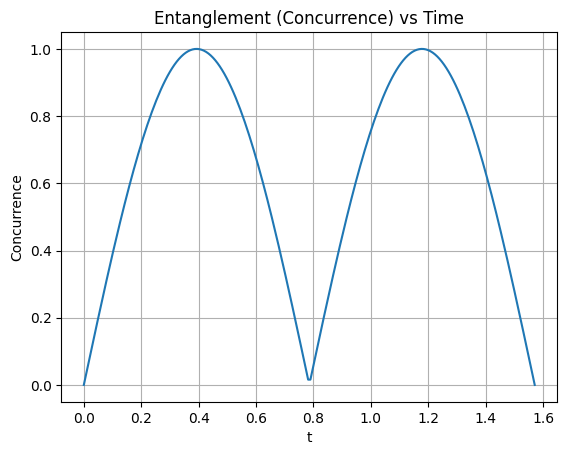

Max concurrence: 0.9999688468941565


In [8]:
plot_concurrence()
